# Environment mmdfuse-env

Not multiplying max{n_0, n_1} to denominator of the objective function 

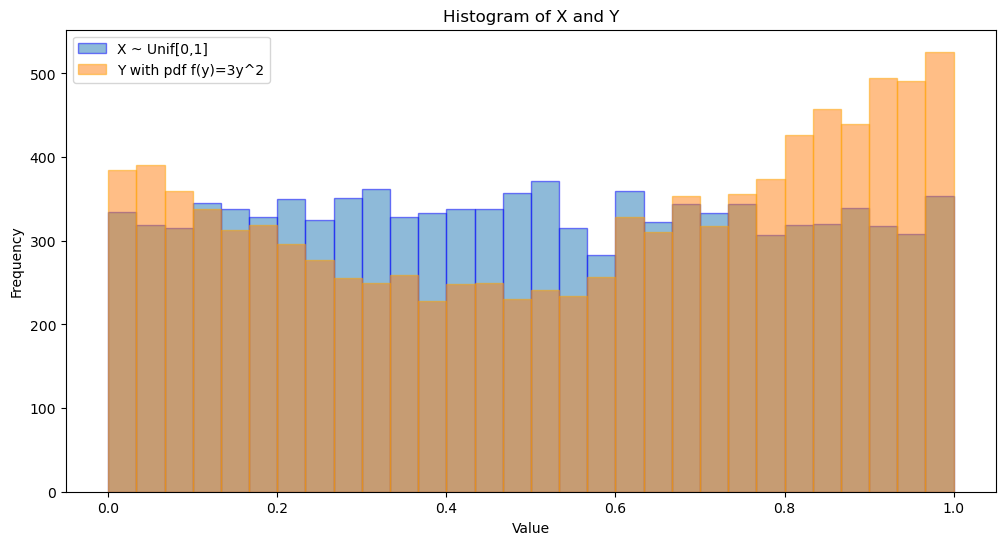

In [13]:
import matplotlib.pyplot as plt
import numpy as np

# Number of samples
n_samples = 10000

# Sample X from Unif[0,1]
X = np.random.uniform(0, 1, n_samples)

# Sample U from Unif[0,1] and then get Y by inverting the CDF of Y
U = np.random.uniform(0, 1, n_samples)
Y = np.cbrt(U)

# Flip f(y) based on x = 1/sqrt(3)
flip_threshold = 1 / np.sqrt(3)
Y[X > flip_threshold] = 1 - Y[X > flip_threshold]

# Plot
plt.figure(figsize=(12, 6))

plt.hist(X, bins=30, alpha=0.5, label='X ~ Unif[0,1]', edgecolor='blue')
plt.hist(Y, bins=30, alpha=0.5, label='Y with pdf f(y)=3y^2', edgecolor='orange')

plt.title('Histogram of X and Y')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.legend()

plt.show()


In [ ]:
%load_ext autoreload 
%autoreload 2

from sampler_galaxy import load_images_list, sampler_galaxy
import jax
import jax.numpy as jnp
from jax import random
from tqdm.auto import tqdm
from pathlib import Path

import torch 
import numpy as np
Path("results").mkdir(exist_ok=True)

In [ ]:
import os
import jax

os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [ ]:
from all_tests import mmdfuse_test
from all_tests import mmd_median_test, mmd_split_test
from all_tests import mmdagg_test, mmdagginc_test
from all_tests import deep_mmd_test, deep_mmd_image_test
from all_tests import met_test, scf_test
from all_tests import ctt_test, actt_test
from tests import c2st_tst
from models import MyModel

In [ ]:
images_list = load_images_list(highres=False)

## Vary difficulty

In [ ]:
# repetitions = 200
# corruptions = (0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4)
# sample_size = 500

# tests = (mmdfuse_test, mmd_median_test, mmd_split_test, mmdagg_test, mmdagginc_test, deep_mmd_test, scf_test, ctt_test, actt_test, deep_mmd_image_test)
# outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
# outputs = outputs.tolist()
# key = random.PRNGKey(42)
# seed = 42
# for s in tqdm(range(len(corruptions))):
#     corruption = corruptions[s]
#     for i in tqdm(range(repetitions)):
#         key, subkey = random.split(key)
#         X, Y = sampler_galaxy(subkey, m=sample_size, n=sample_size, corruption=corruption, images_list=images_list)
#         X = jnp.array(X, dtype=jnp.float32).reshape((X.shape[0], -1))
#         Y = jnp.array(Y, dtype=jnp.float32).reshape((Y.shape[0], -1))
#         key, subkey = random.split(key)
#         seed += 1
#         for t in range(len(tests)):
#             test = tests[t]
#             outputs[t][s][i] = test(
#                 X,
#                 Y,
#                 subkey,
#                 seed,
#             )

# output = jnp.mean(jnp.array(outputs), -1)

# jnp.save("results/galaxy_vary_dif.npy", output)
# jnp.save("results/galaxy_vary_dif_x_axis.npy", corruptions)

# print("corruptions :", corruptions)
# print("sample size :", sample_size)
# for t in range(len(tests)):
#     print(" ")
#     print(tests[t])
#     print(output[t])

## Vary sample size

In [ ]:
# Setting for C2ST
device = 'cuda:0'
dtype = torch.float 
lr = 0.001
n_epoch = 50
alpha = 0.05

In [ ]:
repetitions = 50
corruption = 0.3
m_sample_size = 100
sample_sizes = (10000, 7000, 5000, 3000, 1000, 100)

tests = (c2st_tst, mmdfuse_test, mmd_median_test, mmdagg_test, ctt_test, actt_test)
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
outputs = outputs.tolist()
key = random.PRNGKey(42)
seed = 42
for s in tqdm(range(len(sample_sizes))):
    n_sample_size = sample_sizes[s]
    for i in tqdm(range(repetitions)):
        torch.manual_seed(s + i) 
        torch.cuda.manual_seed(s+i)
        np.random.seed(seed = s+i)
        key, subkey = random.split(key)
        X, Y = sampler_galaxy(subkey, m=m_sample_size, n=n_sample_size, corruption=corruption, images_list=images_list)
        Ind_tr_X = np.random.choice(len(X), int(m_sample_size/2), replace=False)
        Ind_te_X = np.delete(np.arange(len(X)), Ind_tr_X)
        Ind_tr_Y = np.random.choice(len(Y), int(n_sample_size/2), replace=False) 
        Ind_te_Y = np.delete(np.arange(len(Y)), Ind_tr_Y)
        s1_tr = torch.from_numpy(np.array(X[Ind_tr_X])).to(dtype= dtype, device=device)
        s2_tr = torch.from_numpy(np.array(Y[Ind_tr_Y])).to(dtype = dtype, device=device)
        s1_te = torch.from_numpy(np.array(X[Ind_te_X])).to(dtype= dtype, device=device)
        s2_te = torch.from_numpy(np.array(Y[Ind_te_Y])).to(dtype= dtype, device=device)
        X = jnp.array(X, dtype=jnp.float32).reshape((X.shape[0], -1))
        Y = jnp.array(Y, dtype=jnp.float32).reshape((Y.shape[0], -1))
        
        
        key, subkey = random.split(key)
        seed += 1
        for t in range(len(tests)):
            test = tests[t]
            if test == c2st_tst:
                    model = MyModel(in_channels=3, img_size = 64, device=device, dtype=dtype)
                    outputs[t][s][i] = c2st_tst(s1_tr, s2_tr, s1_te, s2_te, model, alpha, lr, n_epoch, seed, 
                                    loss_fn=model.smooth_objective, device=device)
            
            else:
                outputs[t][s][i] = test(
                    X,
                    Y,
                    subkey,
                    seed,
                )

output = jnp.mean(jnp.array(outputs), -1)

jnp.save("results/galaxy_vary_n.npy2", output)
jnp.save("results/galaxy_vary_n_x_axis.npy2", sample_sizes)

print("sample_sizes :", sample_sizes)
print("corruption :", corruption)
for t in range(len(tests)):
    print(" ")
    print(tests[t])
    print(output[t])

# Environment autogluon-env

In [ ]:
from sampler_galaxy import load_images_list, sampler_galaxy
import jax
import jax.numpy as jnp
from jax import random
from tqdm.auto import tqdm
from pathlib import Path
Path("results").mkdir(exist_ok=True)

In [ ]:
import autotst
from utils import HiddenPrints

def autotst_test(X, Y, key, seed, time=60):
    with HiddenPrints():
        tst = autotst.AutoTST(X, Y, split_ratio=0.5, model=autotst.model.AutoGluonTabularPredictor)
        tst.split_data()
        tst.fit_witness(time_limit=time)  # time limit adjustable to your needs (in seconds)
        p_value = tst.p_value_evaluate(permutations=10000)  # control number of permutations in the estimation
    return int(p_value <= 0.05)

In [ ]:
images_list = load_images_list(highres=False)

## Vary difficulty

In [ ]:
repetitions = 200
corruptions = (0.1, 0.15, 0.20, 0.25, 0.3, 0.35, 0.4)
sample_size = 500

tests = (autotst_test, )
outputs = jnp.zeros((len(tests), len(corruptions), repetitions))
outputs = outputs.tolist()
key = random.PRNGKey(42)
seed = 42
for s in tqdm(range(len(corruptions))):
    corruption = corruptions[s]
    for i in tqdm(range(repetitions)):
        key, subkey = random.split(key)
        X, Y = sampler_galaxy(subkey, m=sample_size, n=sample_size, corruption=corruption, images_list=images_list)
        X = jnp.array(X, dtype=jnp.float32).reshape((X.shape[0], -1))
        Y = jnp.array(Y, dtype=jnp.float32).reshape((Y.shape[0], -1))
        key, subkey = random.split(key)
        seed += 1
        for t in range(len(tests)):
            test = tests[t]
            outputs[t][s][i] = test(
                X,
                Y,
                subkey,
                seed,
            )

output = jnp.mean(jnp.array(outputs), -1)

jnp.save("results/galaxy_vary_dif_autotst.npy", output)

print("corruptions :", corruptions)
print("sample size :", sample_size)
for t in range(len(tests)):
    print(" ")
    print(tests[t])
    print(output[t])

## Vary sample size

In [ ]:
repetitions = 200
corruption = 0.15
sample_sizes = (500, 1000, 1500, 2000, 2500, 3000)

tests = (autotst_test, )
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
outputs = outputs.tolist()
key = random.PRNGKey(42)
seed = 42
for s in tqdm(range(len(sample_sizes))):
    sample_size = sample_sizes[s]
    for i in tqdm(range(repetitions)):
        key, subkey = random.split(key)
        X, Y = sampler_galaxy(subkey, m=sample_size, n=sample_size, corruption=corruption, images_list=images_list)
        X = jnp.array(X, dtype=jnp.float32).reshape((X.shape[0], -1))
        Y = jnp.array(Y, dtype=jnp.float32).reshape((Y.shape[0], -1))
        key, subkey = random.split(key)
        seed += 1
        for t in range(len(tests)):
            test = tests[t]
            outputs[t][s][i] = test(
                X,
                Y,
                subkey,
                seed,
            )

output = jnp.mean(jnp.array(outputs), -1)

jnp.save("results/galaxy_vary_n_autotst.npy", output)

print("sample_sizes :", sample_sizes)
print("corruption :", corruption)
for t in range(len(tests)):
    print(" ")
    print(tests[t])
    print(output[t])



In [ ]:
# increase the time limit over the recommended amount
# in order for autotst to have higher power

repetitions = 200
corruption = 0.15
sample_sizes = (500, 1000, 1500, 2000, 2500, 3000)

tests = (autotst_test, )
outputs = jnp.zeros((len(tests), len(sample_sizes), repetitions))
outputs = outputs.tolist()
key = random.PRNGKey(42)
seed = 42
for s in tqdm(range(len(sample_sizes))):
    sample_size = sample_sizes[s]
    for i in tqdm(range(repetitions)):
        key, subkey = random.split(key)
        X, Y = sampler_galaxy(subkey, m=sample_size, n=sample_size, corruption=corruption, images_list=images_list)
        X = jnp.array(X, dtype=jnp.float32).reshape((X.shape[0], -1))
        Y = jnp.array(Y, dtype=jnp.float32).reshape((Y.shape[0], -1))
        key, subkey = random.split(key)
        seed += 1
        for t in range(len(tests)):
            test = tests[t]
            outputs[t][s][i] = test(
                X,
                Y,
                subkey,
                seed,
                time=3 * 60,
            )

output = jnp.mean(jnp.array(outputs), -1)

jnp.save("results/galaxy_vary_n_autotst_3min.npy", output)

print("sample_sizes :", sample_sizes)
print("corruption :", corruption)
for t in range(len(tests)):
    print(" ")
    print(tests[t])
    print(output[t])
